#### kaggle竞赛

本节将动手操作实践一个kaggle比赛，房价预测。
可以先将未经优化的数据的预处理，模型的设计和超参的选择，可以动手操作，观察实现的过程以及结果，

####  获取和读取数据集

 比赛的数据分为训练数据集和测试数据集。两个数据集都包括每栋房子的特征，如阶段类型，建造年份，房顶类型，地下室状况等特征值。这些特征值有连续的数字、离散的的标签甚至是缺失值Na，只有训练数据集包括了每栋房子的价格。我们可以通过Kaggle竞赛提供的接口访问并下载该数据集。

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
import d2lzh_pytorch as d2l
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.0.0


In [2]:
# 我们将数据解压缩之后放入当前目录下的../data/kaggle_house/文件夹下
train_data = pd.read_csv('data/kaggle_house/train.csv')
test_data = pd.read_csv('data/kaggle_house/test.csv')


In [3]:
#查看训练集包括的样本量以及特征量
train_data.shape

(1460, 81)

In [4]:
#查看测试集包括的样本量以及特征量
test_data.shape

(1459, 80)

In [5]:
# 先来看下训练数据集的前4个样本的前4个特征和最后两个特征以及标签
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


可以看到第一个特征是Id，它能帮助模型记住每个训练样本，但是难以推广到测试样本，所以我们不适用它来训练，我们将所有的训练和测试样本的79个特征按照样本连接。

In [6]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]),sort=False)

# 传入新的sort=False参数，保持默认的顺序进行数据连接

In [7]:
all_features.iloc[0:4,[0,1,2,-3,-2,-1]]
# 可以进一步核对的训练数据与样本数据的一致性

,MSSubClass,MSZoning,LotFrontage,YrSold,SaleType,SaleCondition
0,60,RL,65.0,2008,WD,Normal
1,20,RL,80.0,2007,WD,Normal
2,60,RL,68.0,2008,WD,Normal
3,70,RL,60.0,2006,WD,Abnorml


#### 数据预处理

In [8]:
all_features.dtypes
# 查看特征的数据类型

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
                  ...   
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object


我们对连续数值的特征做标准化处理(standardization)： 设定该特征在整个数据集上的均值为$\mu， 标准差为\sigma。那么，我们可以将特征值的每个特征先减去\mu 再除以\sigma$得到标准化后的每个特征值。对于确实的特征值，我们将其替换成该特征的均值

##### 找出所有数值型的特征，然后标准化

In [9]:
numeric_features = all_features.dtypes[all_features.dtypes!='object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
lambda x: (x-x.mean())/(x.std())
)
# 标准化后，每个特征的均值变为0，所以可以直接用0来替换缺失值
all_features = all_features.fillna(0)

##### 处理离散值特征

In [10]:
all_features = pd.get_dummies(all_features,dummy_na=True)
# dummy_na= True,将缺失值也当做合法的特征值并为其创建指标的特征
all_features.shape


(2919, 354)

##### 转化为DNArray后续训练

In [11]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values,dtype=torch.float).view(-1,1)

#### 训练模型

In [12]:
loss = torch.nn.MSELoss()
def get_net(feature_num):
    net = nn.Linear(feature_num,1)
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return net

In [13]:
loss

MSELoss()

根据比赛的评估模型的对数均方根误差，给定预测值$\hat{y}_{1},....\hat{y}_{n}$和对应真实的标签 $y_{1},...y_{n}$ 它的定义为

$$
\sqrt { \frac { 1 } { n } \sum _ { i = 1 } ^ { n } \left( \log \left( y _ { i } \right) - \log \left( \hat { y } _ { i } \right) \right) ^ { 2 } }
$$
对数均方根误差的实现日下。

In [14]:
def log_rmse(net,features,labels):
    with torch.no_grad():
        # 将小于1的值设定成1，似的取对数值更稳定
        clipped_preds = torch.max(net(features),torch.tensor(1.0))
        rmse  = torch.sqrt(2*loss(clipped_preds.log(),labels.log())).mean()
        
    return rmse.item()

下面的训练函数跟本章的前几节的不同之处在与使用了Adam优化算法。相对之前使用的小批量随机梯度下降，它对学习率相对不那么敏感。我们后续还会继续介绍该优化算法。

In [26]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

#### k折交叉验证

在之前的模型选择、欠拟合、过拟合的章节中介绍了K折交叉验证。它将用来选择模型设计并调价参数。
下面实现咯额一个函数，它返货第i折交叉验证是所需的训练和验证数据


In [27]:
def get_k_fold_data(k,i,X,y):
    # 返回第i 折交叉验证时所需要的训练和验证数据
    assert k>1
    fold_size = X.shape[0]//k
    X_train,y_train = None,None
    for j in range(k):
        idx = slice(j * fold_size,(j+1)*fold_size)
        X_part,y_part = X[idx,:],y[idx]
        if j==i:   #  没有验证数据，全部用来训练
            X_valid,y_valid = X_part,y_part
        elif X_train is None:
            X_train,y_train = X_part,y_part
        else:
            X_train = torch.cat((X_train,X_part),dim=0)
            y_train = torch.cat((y_train,y_part),dim=0)
    return X_train,y_train,X_valid,y_valid 
        

在K折交叉验证中我们训练K次并返回训练和验证的平均误差

In [28]:

def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.240307, valid rmse 0.221751
fold 1, train rmse 0.229595, valid rmse 0.265282
fold 2, train rmse 0.232500, valid rmse 0.238713
fold 3, train rmse 0.236631, valid rmse 0.218289
fold 4, train rmse 0.230635, valid rmse 0.258359
5-fold validation: avg train rmse 0.233934, avg valid rmse 0.240479


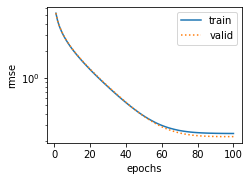

In [29]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f'
      % (k, train_l, valid_l))

#### 预测样本，并提交结果

In [30]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

train rmse 0.229653


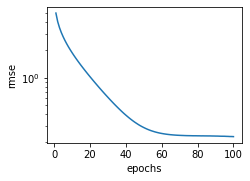

In [31]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)
